# Matteo_Challenge1: ResNet Solution

## Import libraries

In [74]:
import os
import random
from datetime import datetime

import splitfolders

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import confusion_matrix
from keras.models import load_model
from keras.layers import Dropout
from tensorflow.keras.applications.resnet50 import preprocess_input

from keras.layers import BatchNormalization
from keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [75]:
# Checking tensorflow version
tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.10.0


In [76]:
# Setting seed for reproducibility
seed = 42
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

## Model Parameters and Classes Weights

In [77]:
labels = ['Species1',      # 0
          'Species2',      # 1
          'Species3',      # 2
          'Species4',      # 3
          'Species5',      # 4
          'Species6',      # 5
          'Species7',      # 6
          'Species8']      # 7

In [78]:
class_weights = {0: 2.389358108108108,
                 1: 0.8320588235294117,
                 2: 0.8583131067961165,
                 3: 0.8667279411764706,
                 4: 0.8340212264150944,
                 5: 1.9978813559322033,
                 6: 0.8243006993006993,
                 7: 0.8709975369458128}

## Model Parameters and Metadata

In [79]:
# Input Parameters
img_w = 96
img_h = 96
input_shape = (96, 96, 3)
classes = 8

# Training Parameters
epochs = 200
batch_size = 32
reg_rate = 0.001

# Earlystopping Parameters
early_stopping = True
patience_epochs = 10

In [80]:
# Paths
dataset_dir = 'data5/data5'
training_dir = os.path.join(dataset_dir, 'training')
validation_dir = os.path.join(dataset_dir, 'validation')
#testing_dir = os.path.join(dataset_dir, 'testing')

In [81]:
def get_next_batch(generator):
    batch = next(generator)

    image = batch[0]*255
    target = batch[1]

    print("(Input) image shape:", image.shape)
    print("Target shape:",target.shape)

    # Visualize only the first sample
    image = image[0]
    target = target[0]
    target_idx = np.argmax(target)
    print()
    print("Categorical label:", target)
    print("Label:", target_idx)
    print("Class name:", labels[target_idx])
    fig = plt.figure(figsize=(6, 4))
    plt.imshow(np.uint8(image))

    return batch

## Data Augmentation

### Training

In [88]:
# Constructor
aug_train_data_gen = ImageDataGenerator(rotation_range=50,
                                        height_shift_range=5,
                                        width_shift_range=5,
                                        zoom_range=0.2,
                                        shear_range=0.1,
                                        horizontal_flip=True,
                                        vertical_flip=True,
                                        fill_mode='reflect',
                                        rescale=1/255.)

# Generator
aug_train_gen = aug_train_data_gen.flow_from_directory(directory=training_dir,
                                                       target_size=(96,96),
                                                       interpolation="bicubic",
                                                       color_mode='rgb',
                                                       classes=labels,
                                                       batch_size=batch_size,
                                                       shuffle=True,
                                                       seed=seed)

Found 2656 images belonging to 8 classes.


(Input) image shape: (32, 96, 96, 3)
Target shape: (32, 8)

Categorical label: [0. 0. 1. 0. 0. 0. 0. 0.]
Label: 2
Class name: Species3


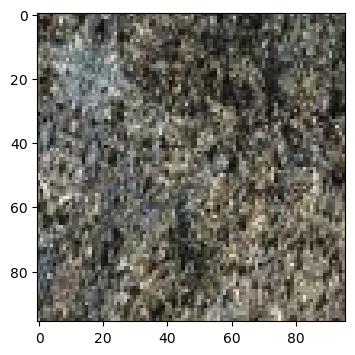

In [89]:
# Get a sample from dataset and show info
_ = get_next_batch(aug_train_gen)

 #### Validation

In [90]:
# Constructor
valid_data_gen = ImageDataGenerator(rescale = 1./255.)
# Generator
valid_gen = valid_data_gen.flow_from_directory(directory=validation_dir,
                                               target_size=(96, 96),
                                               color_mode='rgb',
                                               interpolation="bicubic",
                                               classes=labels,
                                               batch_size=batch_size,
                                               shuffle=True,
                                               seed=seed)

Found 886 images belonging to 8 classes.


#### Testing

In [91]:

# Constructor
test_data_gen = ImageDataGenerator(
    rescale = 1./255.
)

# Generator
test_gen = test_data_gen.flow_from_directory(
    directory=testing_dir,
    target_size=(96, 96),
    color_mode='rgb',
    classes=None,
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=False,
    seed=seed
)

NameError: name 'testing_dir' is not defined

## CNN Transfer Learning Model

### Utility Callbacks

In [92]:
# Utility function to create folders and callbacks for training
def create_folders_and_callbacks(model_name) :
    exps_dir = os.path.join('data_augmentation_experiments')
    if not os.path.exists(exps_dir):
        os.makedirs(exps_dir)

    now = datetime.now().strftime('%b%d_%H-%M-%S')

    exp_dir = os.path.join(exps_dir, model_name + '_' + str(now))
    if not os.path.exists(exp_dir):
        os.makedirs(exp_dir)

    callbacks = []
    """
    # Model checkpoint ---------------------------------------------------
    ckpt_dir = os.path.join(exp_dir, 'ckpts')
    if not os.path.exists(ckpt_dir):
        os.makedirs(ckpt_dir)

    ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp'), # filepath is where I want to save the model
                                                     save_weights_only=False, # save only the weights ora all the model
                                                     save_best_only=True) # if True saves only the results of the best epoch

    callbacks.append(ckpt_callback)
    """

    # Visualize Learning on Tensorboard ----------------------------------
    tb_dir = os.path.join(exp_dir, 'tb_logs') # logs where we save the events, where the tensorboard will read the logs
    if not os.path.exists(tb_dir):
        os.makedirs(tb_dir)

    tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir,
                                              profile_batch=0,
                                              histogram_freq=1)
    callbacks.append(tb_callback)

    # Early Stopping -----------------------------------------------------
    if early_stopping:
        es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience_epochs, restore_best_weights=True)
        callbacks.append(es_callback)

    return callbacks

### Model

In [93]:
supernet = tf.keras.applications.DenseNet201(
    include_top=False,
    weights="imagenet",
    input_shape=(96,96,3),
)

supernet.trainable = True

for i, layer in enumerate(supernet.layers[:95]):
  layer.trainable=False

for i, layer in enumerate(supernet.layers):
   print(i, layer.name, layer.trainable)

0 input_8 False
1 zero_padding2d_6 False
2 conv1/conv False
3 conv1/bn False
4 conv1/relu False
5 zero_padding2d_7 False
6 pool1 False
7 conv2_block1_0_bn False
8 conv2_block1_0_relu False
9 conv2_block1_1_conv False
10 conv2_block1_1_bn False
11 conv2_block1_1_relu False
12 conv2_block1_2_conv False
13 conv2_block1_concat False
14 conv2_block2_0_bn False
15 conv2_block2_0_relu False
16 conv2_block2_1_conv False
17 conv2_block2_1_bn False
18 conv2_block2_1_relu False
19 conv2_block2_2_conv False
20 conv2_block2_concat False
21 conv2_block3_0_bn False
22 conv2_block3_0_relu False
23 conv2_block3_1_conv False
24 conv2_block3_1_bn False
25 conv2_block3_1_relu False
26 conv2_block3_2_conv False
27 conv2_block3_concat False
28 conv2_block4_0_bn False
29 conv2_block4_0_relu False
30 conv2_block4_1_conv False
31 conv2_block4_1_bn False
32 conv2_block4_1_relu False
33 conv2_block4_2_conv False
34 conv2_block4_concat False
35 conv2_block5_0_bn False
36 conv2_block5_0_relu False
37 conv2_block5_

In [94]:
# Use the supernet as feature extractor

inputs = tfk.Input(shape=input_shape)

x = supernet(inputs)

# Global Average Pooling -----------------------------------------------------------
glob_pooling = tfkl.GlobalAveragePooling2D(name='GlobalPooling')(x)

dropout_layer1 = tfkl.Dropout(0.3, seed=seed)(glob_pooling)#era 0.2

# Dense Layer -----------------------------------------------------------
#classifier_layer1 = tfkl.Dense(units=128,
#                                kernel_initializer=tfk.initializers.GlorotUniform(seed),
#                                kernel_regularizer = l2(0.01)
#                                )(dropout_layer1)

#classifier_layer1 = tfkl.ReLU()(dropout_layer1)
#classifier_layer1 = tfkl.BatchNormalization()(classifier_layer1)


classifier_layer2 = tfkl.Dense(units=512,#era 128
                                kernel_initializer=tfk.initializers.GlorotUniform(seed),
                                kernel_regularizer = l2(0.0001)#non c'era
                                #)(classifier_layer1)
                                )(dropout_layer1)
                               
classifier_layer2 = tfkl.ReLU()(classifier_layer2)
classifier_layer2 = tfkl.BatchNormalization()(classifier_layer2)


#classifier_layer2 = tfkl.Dropout(0.3, seed=seed)(classifier_layer2)

# Output Layer -----------------------------------------------------------
output_layer = tfkl.Dense(units=8,
                          activation='softmax',
                          kernel_initializer=tfk.initializers.GlorotUniform(seed),
                          name='output_layer')(classifier_layer2)


# Connect input and output through the Model class
densnet_Model = tfk.Model(inputs=inputs, outputs=output_layer, name='model')

# Compile the model
densnet_Model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(1e-4), metrics=['accuracy'])

densnet_Model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 densenet201 (Functional)    (None, 3, 3, 1920)        18321984  
                                                                 
 GlobalPooling (GlobalAverag  (None, 1920)             0         
 ePooling2D)                                                     
                                                                 
 dropout_3 (Dropout)         (None, 1920)              0         
                                                                 
 dense_3 (Dense)             (None, 512)               983552    
                                                                 
 re_lu_7 (ReLU)              (None, 512)               0         
                                                             

## Training

In [95]:
# Create folders and callbacks and fit
callbacks = create_folders_and_callbacks(model_name='DenseNetNew')

# Train the model
history = densnet_Model.fit(
    x = aug_train_gen,
    epochs = 200,
    validation_data = valid_gen,
    class_weight=class_weights,
    callbacks = callbacks,
).history

Epoch 1/200
83/83 [==============================] - 441s 5s/step - loss: 1.9695 - accuracy: 0.3641 - val_loss: 1.6106 - val_accuracy: 0.4898
Epoch 2/200
83/83 [==============================] - 394s 5s/step - loss: 1.2619 - accuracy: 0.5964 - val_loss: 1.1160 - val_accuracy: 0.6321
Epoch 3/200
83/83 [==============================] - 372s 4s/step - loss: 1.0242 - accuracy: 0.6732 - val_loss: 0.9001 - val_accuracy: 0.7291
Epoch 4/200
83/83 [==============================] - 377s 5s/step - loss: 0.8526 - accuracy: 0.7180 - val_loss: 0.6601 - val_accuracy: 0.7946
Epoch 5/200
83/83 [==============================] - 390s 5s/step - loss: 0.7506 - accuracy: 0.7572 - val_loss: 0.4997 - val_accuracy: 0.8454
Epoch 6/200
83/83 [==============================] - 384s 5s/step - loss: 0.6449 - accuracy: 0.7925 - val_loss: 0.4470 - val_accuracy: 0.8600
Epoch 7/200
83/83 [==============================] - 378s 5s/step - loss: 0.5868 - accuracy: 0.8065 - val_loss: 0.3972 - val_accuracy: 0.8871
Epoch 

In [1]:
# Saving the last epoch of the train
save_dir = os.path.join('models/NewDense')
densnet_Model.save(save_dir)

NameError: name 'os' is not defined

In [ ]:
#fine tuning
del model
model = tfk.models.load_model('models/TLDenseNetNew')
model.summary()

In [ ]:
for layer in model.layers[:95]:
    layer.trainable = True
model.summary()

In [ ]:
# Compile the model
model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(1e-5), metrics='accuracy')

In [ ]:
# Fine-tune the model
model.fit(
    x = aug_train_gen,
    batch_size = batch_size,
    epochs = epochs,
    validation_data=val_gen,
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True)]
)

In [ ]:
model.save('testing_x/DenseTuned')

## Graphs Visualization

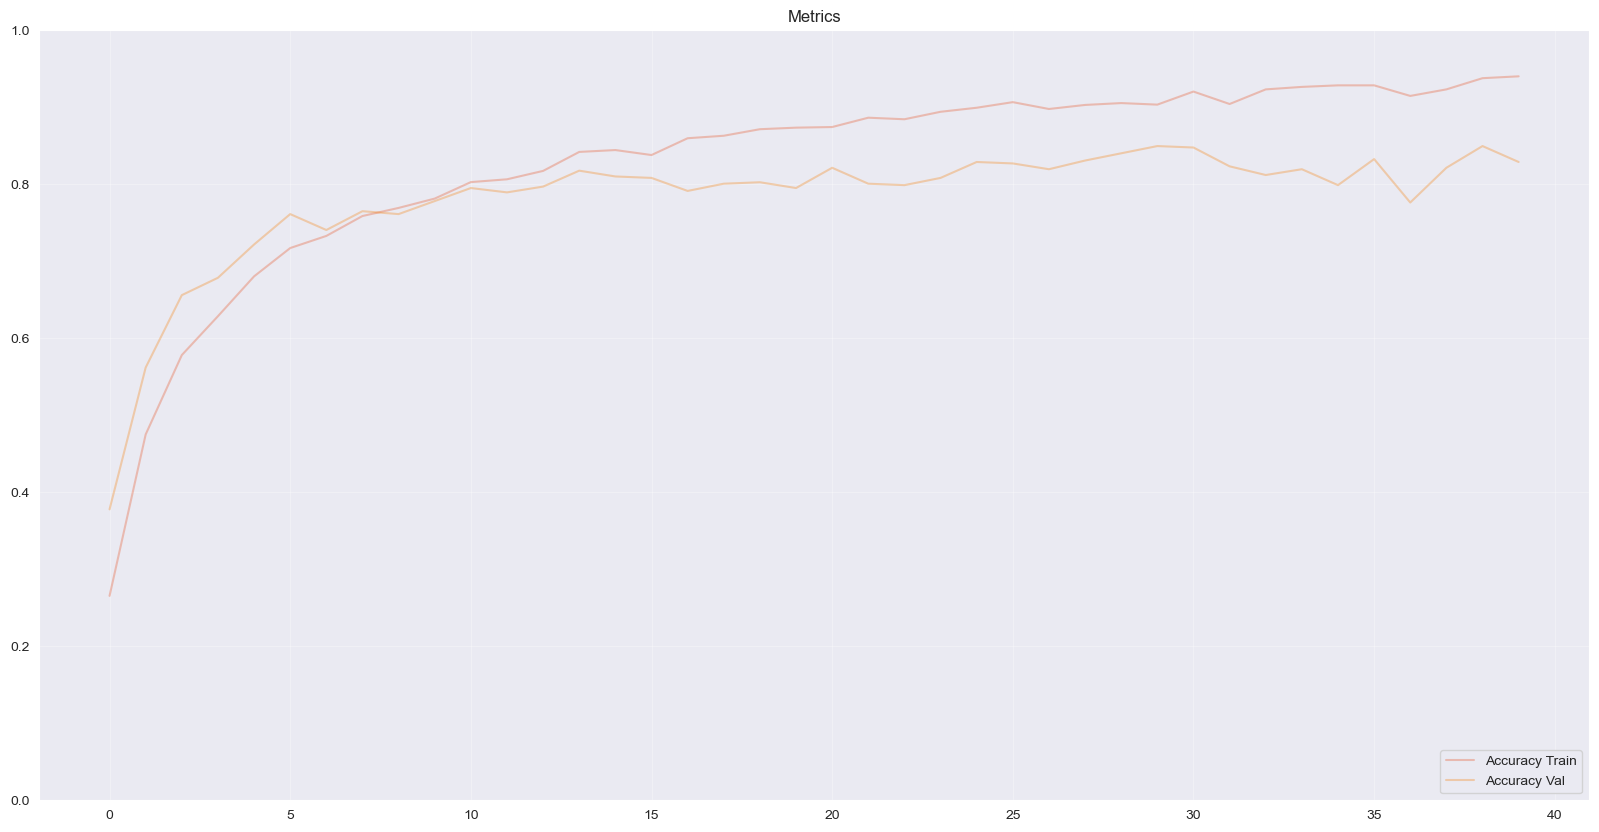

In [30]:
# All the metrics : Accuracy, Precision and Recall
ALPHA = 0.3

plt.figure(figsize=(20,10))

plt.plot(history['accuracy'], label='Accuracy Train', alpha=ALPHA, color='#E64A19')
plt.plot(history['val_accuracy'], label='Accuracy Val', alpha=ALPHA, color='#F57C00')

plt.ylim(0, 1)
plt.title('Metrics')
plt.legend(loc='lower right')
plt.grid(alpha=.3)
plt.show()

## Confusion Matrix

In [31]:
test_steps_per_epoch = np.math.ceil(test_gen.samples / test_gen.batch_size)

# Evaluate on test
predictions = densnet_Model.predict(test_gen, steps=test_steps_per_epoch)

2022-11-19 20:33:05.917535: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


34/34 [==============================] - 14s 218ms/step


In [32]:
# Get most likely classes
predicted_classes = np.argmax(predictions, axis=-1)

In [33]:
# Get true classes
true_classes = test_gen.classes
class_labels = list(test_gen.class_indices.keys())

Accuracy: 0.8748
Precision: 0.8504
Recall: 0.833
F1: 0.838


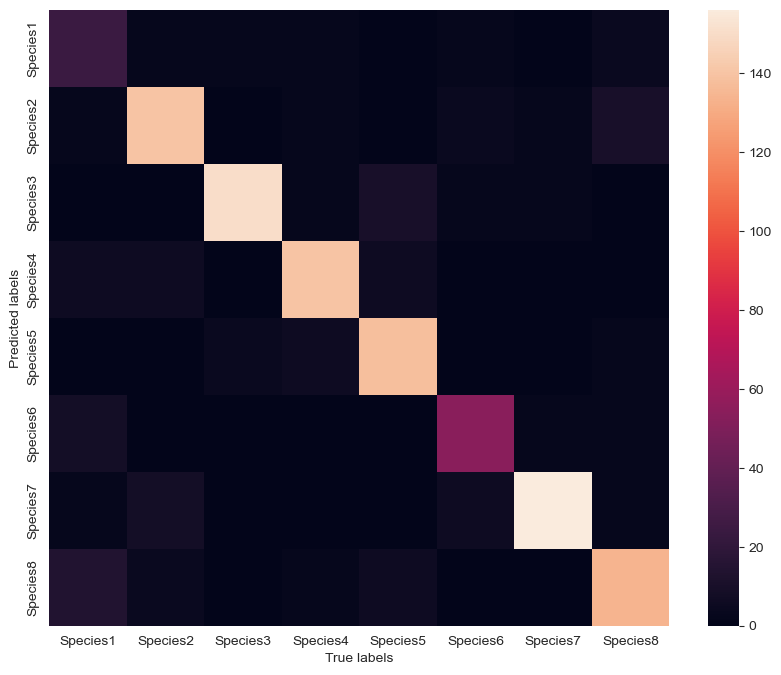

In [34]:
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score

# Compute the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Compute the classification metrics
accuracy = accuracy_score(true_classes, predicted_classes)
precision = precision_score(true_classes, predicted_classes, average='macro')
recall = recall_score(true_classes, predicted_classes, average='macro')
f1 = f1_score(true_classes, predicted_classes, average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm.T, xticklabels=list(class_labels), yticklabels=class_labels)
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()